In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
import jinns
import jax
from jax import random, vmap
import jax.numpy as jnp
import equinox as eqx
from functools import partial

import matplotlib.pyplot as plt

key = random.PRNGKey(2)


# Pre-create the same pytree structure

In [3]:
eqx_list = [
    [eqx.nn.Linear, 3, 16],
    [jax.nn.swish],
    [eqx.nn.Linear, 16, 16],
    [jax.nn.swish],
    [eqx.nn.Linear, 16, 16],
    [jax.nn.swish],
    [eqx.nn.Linear, 16, 16],
    [jax.nn.swish],
    [eqx.nn.Linear, 16, 16],
    [jax.nn.swish],
    [eqx.nn.Linear, 16, 16],
    [jax.nn.swish],
    [eqx.nn.Linear, 16, 1],
    #[jax.nn.softplus]
]

eqx_list_hyper = [
    [eqx.nn.Linear, 2, 32], # input is of size 2 for scalar D and scalar r
    [jax.nn.tanh],
    [eqx.nn.Linear, 32, 32],
    [jax.nn.tanh],
    [eqx.nn.Linear, 32, 32],
    [jax.nn.tanh],
    [eqx.nn.Linear, 32, 32],
    [jax.nn.tanh],
    [eqx.nn.Linear, 32, 32],
    [jax.nn.tanh],
    [eqx.nn.Linear, 32, 32],
    [jax.nn.tanh],
    [eqx.nn.Linear, 32, 1000], # 1000 is a random guess, it will automatically be filled with the correct value
]
key, subkey = random.split(key)

hyperparams = ["D", "r"]
hypernet_input_size = 2

dim_x = 2

u_structure = jinns.utils.create_HYPERPINN(subkey, eqx_list, "nonstatio_PDE", hyperparams, hypernet_input_size, dim_x, eqx_list_hyper=eqx_list_hyper)

In [4]:
import pickle

n_iter = 30000
filename = f"./metamodel-reacdiff-{n_iter}iter"  

# deserialize the hyperPINN
u = eqx.tree_deserialise_leaves(filename + "-model.eqx", u_structure)
jax.tree_util.tree_structure(u) == jax.tree_util.tree_structure(u_structure)

# unpickle param
with open(filename + "-parameters.pkl", 'rb') as f:
    params = pickle.load(f)


In [5]:
Tmax = 50
xmin = 0
xmax = 50
ymin = 0
ymax = 50

Tmax = 50

g = 1

t_ind = jnp.array([0, 1, 10, 25, 48, 50])
times = jnp.round(t_ind * 1. / Tmax, decimals=2) 
nx, ny = 50, 50
val_xy_data = [
    jnp.linspace(xmin, xmax, nx),
    jnp.linspace(ymin, ymax, ny)
]

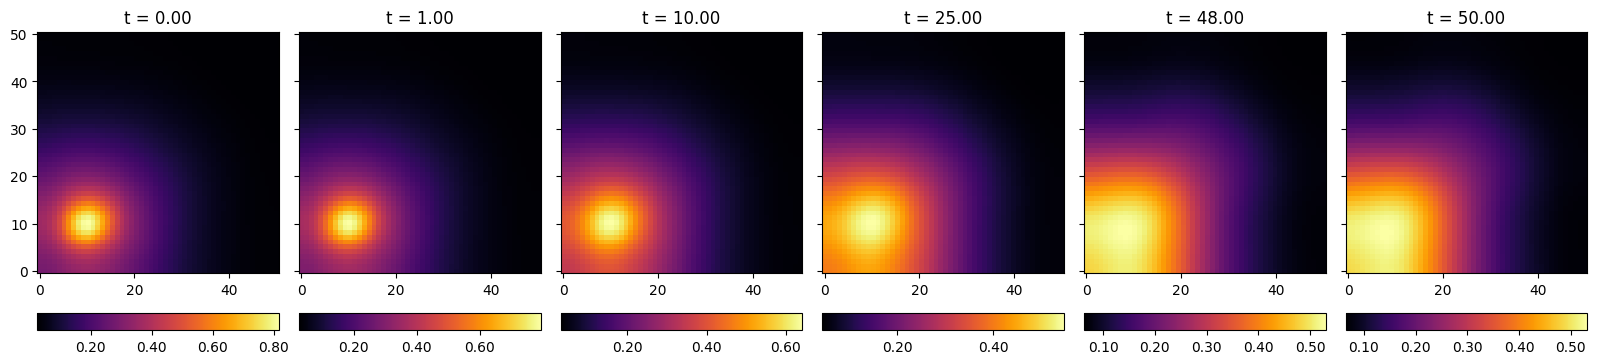

In [11]:
u_est = lambda t, x: u(t, x, {"nn_params":params["nn_params"], "eq_params":{"g":g, "D":jnp.array([0.5]), "r":jnp.array([0])}})
jinns.data.plot2d(
    fun=u_est,
    xy_data=val_xy_data,
    times = times,
    Tmax=Tmax,
    title="u0(x,y)",
    figsize=(20, 20*len(times))
)

# Diffrax finite difference solver

In [12]:
from jinns.experimental import SpatialDiscretisation, plot_diffrax_solution, reaction_diffusion_2d_vector_field
import diffrax

# Spatial discretisation
xmin, xmax = 0, 50
ymin, ymax = 0, 50
nx, ny = 50, 50

y0 = SpatialDiscretisation.discretise_fn(xmin, xmax, ymin, ymax, nx, ny, u0)

# Temporal discretisation
times_save_dfx = jnp.arange(0, Tmax+1)

# Tolerances for non-stiff problems
rtol = 1e-3
atol = 1e-6
# Tolerances for stiff problems (along with using float64)
# rtol = 1e-7
# atol = 1e-9
stepsize_controller = diffrax.PIDController(
    pcoeff=0.3, icoeff=0.4, rtol=rtol, atol=atol, dtmax=1
)

solver = diffrax.Dopri5()
max_steps = int(1e6)
saveat = (times_save_dfx,)

xbounds = (xmin, xmax)
ybounds = (ymin, ymax)

dt0 = 0.05
diffeqsolve_kwargs = {
    "t0": 0,
    "t1": int(times_save_dfx.max()),
    "dt0": dt0,
    "y0": y0,
    "saveat": diffrax.SaveAt(ts=times_save_dfx),
    "stepsize_controller": stepsize_controller,
    "max_steps": max_steps,
    "solver": solver,
}

NameError: name 'u0' is not defined

In [ ]:


term = diffrax.ODETerm(reaction_diffusion_2d_vector_field)
diffrax_solution = diffrax.diffeqsolve(term, **diffeqsolve_kwargs)
print(f"r={float(r):.2f},D={float(D):.2f}")
plot_diffrax_solution(diffrax_solution, xbounds, ybounds, t_ind=t_ind)